In [1]:
!pip install rasterio

In [17]:
import zipfile

import matplotlib.pyplot as plt
import pandas as pd

from hda import Client

import rasterio
from rasterio.windows import Window
from rasterio.plot import show
from rasterio.enums import Resampling

%run helpers.ipynb

# 1. Get Data

In [3]:
data = {
    "datasetId": "EO:CLMS:DAT:CORINE",
    "stringChoiceValues": [
        {
            "name": "product_type",
            "value": "Corine Land Cover 2018"
        },
        {
            "name": "format",
            "value": "GeoTiff100mt"
        }
    ]
}

In [4]:
c = Client(debug=False)

matches = c.search(data)
matches.download()

Exception: Missing/incomplete configuration file: /home/jovyan/.hdarc

In [ ]:
zip_ref = zipfile.ZipFile("u2018_clc2018_v2020_20u1_raster100m.zip")
zip_ref.extractall("./data")
zip_ref.close() # close file

# 2. Set Path

In [5]:
tif_path = 'data/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif'

## 2.1 Work with Rasterio

In [6]:
dataset = rasterio.open(tif_path)

2022-07-21 14:49:38,388 WARNING CPLE_AppDefined in The definition of projected CRS EPSG:3035 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


In [7]:
# show data information
print("Count:",dataset.count)
print()
print("CRS:", dataset.crs)
print()
print("Width:", dataset.width, "Height", dataset.height)

Count: 1

CRS: PROJCS["ETRS_1989_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]

Width: 65000 Height 46000


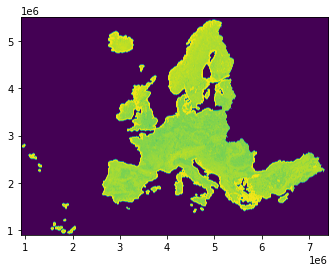

<AxesSubplot:>

In [9]:
# show complete data
show(dataset)

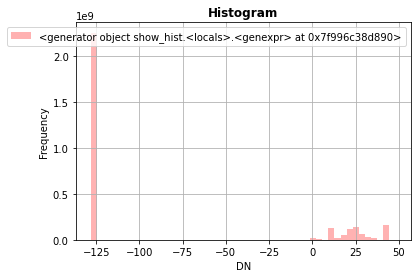

In [10]:

from rasterio.plot import show_hist

show_hist(dataset, bins=50, lw=0.0, stacked=False, alpha=0.3,
      histtype='stepfilled', title="Histogram")



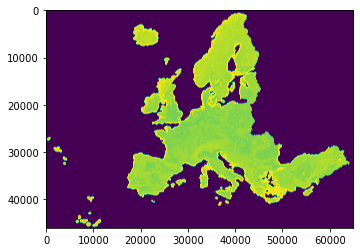

In [11]:
plt.imshow(dataset.read(1))
plt.show()

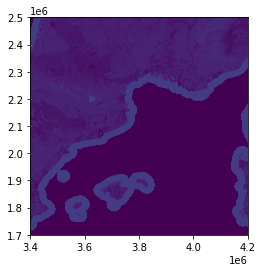

<AxesSubplot:>

In [12]:
# show specific region data


# X coordinate, Y coordinate, Width, height
window = Window(25000, 30000, 8000, 8000)

data_cropped = dataset.read(window=window, masked=True)
show(data_cropped, transform=dataset.window_transform(window), vmin=0, vmax=255)

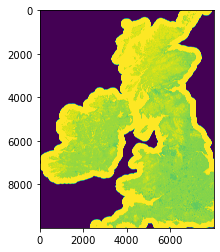

In [13]:
#render same graph using pyplot
window = Window(20000, 14000, 8000, 10000)
data_cropped = dataset.read(window=window, masked=True)
plt.imshow(data_cropped.squeeze())
plt.show()

# 3. Work with data

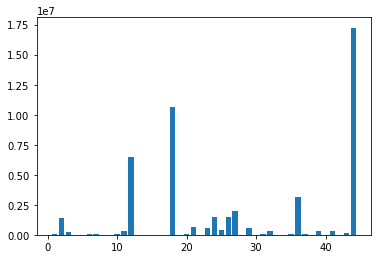

In [40]:
ledgend = pd.read_csv("data/u2018_clc2018_v2020_20u1_geoPackage/Legend/CLC_legend.csv", delimiter = ";")
ledgend["RGB"] = ledgend["RGB"].fillna("000-000-000")
ledgend["RGB"] = ledgend["RGB"].apply(lambda c : '#%02x%02x%02x'%tuple(int(x) for x in c.split("-"))) # convert RGB to hex
code_color = pd.Series(ledgend.RGB.values,index=ledgend.CLC_CODE).to_dict()
code_gridcode = pd.Series(ledgend.GRID_CODE.values,index=ledgend.CLC_CODE).to_dict()
gridcode_color = pd.Series(ledgend.RGB.values,index=ledgend.GRID_CODE).to_dict()


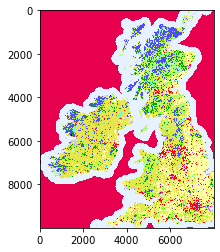

In [44]:
import matplotlib as mpl
from matplotlib import pyplot
import numpy as np



# make a color map of fixed colors
cmap = mpl.colors.ListedColormap(gridcode_color.values())
bounds=np.array(list(gridcode_color.keys())) 
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# tell imshow about color map so that only set colors are used
img = pyplot.imshow(data_cropped.squeeze(),interpolation='nearest',
                    cmap = cmap,norm=norm )


pyplot.show()

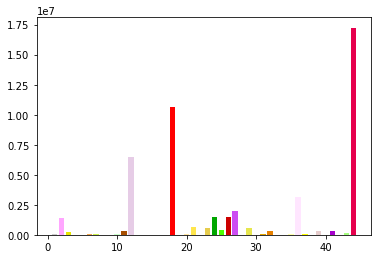

In [47]:
from collections import Counter
d = Counter(data_cropped.flatten().tolist())
d.pop(-128)



plt.bar(d.keys(), d.values(),color=gridcode_color.values())

plt.show()